In [1]:
import sys
sys.path.append('/work/mh0731/m300876/package/')
import icons
import intake
import cartopy as cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import healpy as hp
import xarray as xr
import numpy as np
import easygems.healpix as egh
from scipy.ndimage import gaussian_filter
from pathlib import Path
import seaborn as sns
import pandas as pd

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
icons.prepare_cpu(memory='100GB')

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/m300876/levante-spawner-preset//proxy/8787/status,Workers: 1
Total threads: 256,Total memory: 93.13 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.85/2046149/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-preset//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 93.13 GiB
Comm: inproc://136.172.120.85/2046149/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-preset//proxy/40729/status,Memory: 93.13 GiB
Nanny: None,


### Predefined functions

In [3]:
def preprocess(ds):
    """
    Adapts precipitation to the needs of this notebook.
    """
    ds = ds.assign(pr=(ds.pr * 86400).assign_attrs(units="mm d-1"))
    return ds

### Location mask
def tropics(ds):
    return np.abs(ds.lat) <= 30.1

def ocean(ds):
    return ds.ocean_fraction_surface == 1

def trop_wpacific(ds):
    return tropics(ds) & (ds.lon > 150) & (ds.lon < 170) 

#### calculate mean in IMERG
def time_clim_imerg(file, times, lat):
    dset1 = xr.open_mfdataset(
        file, combine="by_coords", chunks=({"time": 20}), engine="netcdf4"
    )
    pr = (
        dset1["calibrated_precipitation"]
        .sel(time=slice(times[0], times[1]), lat=slice(lat[0], lat[1]))
        .groupby("time.month")
        .mean()
    )
    return pr.compute()


## Calling data

In [5]:
%%time
### ICON
current_location = "online"
cat = cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
exp_name = "icon_d3hp003"
experiment = cat[exp_name]
time_slice = slice("2020-02-01", "2021-01-31")
ds_icon = (
    experiment(zoom=8, time="P1D", chunks="auto")
    .to_dask()
    .pipe(egh.attach_coords)
    .pipe(preprocess)
    .sel(time=time_slice)
)

pr_icon = ds_icon.pr.where(tropics(ds_icon)).mean("time").compute()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


In [7]:
%%time
### NICAM
exp_name = "nicam"
experiment = cat[exp_name]
time_slice = slice("2020-04-01", "2021-03-31")
ds_nicam = (
    experiment(zoom=8, time="PT3H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_nicam = ds_nicam.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

pr_nicam = ds_nicam.pr.where(tropics(ds_nicam)).mean("time").compute()

CPU times: user 1min 39s, sys: 39 s, total: 2min 18s
Wall time: 1min 30s


In [8]:
%%time
### UM
exp_name = "um_glm_n2560_RAL3p3"
experiment = cat[exp_name]
time_slice = slice("2020-03-01", "2021-03-01")
ds_um = (
    experiment(zoom=8, time="PT1H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_um = ds_um.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

pr_um = ds_um.pr.where(tropics(ds_um)).mean("time").compute()

CPU times: user 1min 51s, sys: 1min 9s, total: 3min
Wall time: 1min 19s


In [9]:
%%time
## IMERG

# Define a global pattern to find the files
glob_pattern_3d1 = "IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_"
## Define the paths of IMERG
data_path1 = Path(
    "/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG"
)
## Collect all file names with pathlib'
file_imerg = sorted([str(f) for f in data_path1.rglob(f"*{glob_pattern_3d1}*.nc")])[:]
pr_imerg = time_clim_imerg(file_imerg, ["2001-01-01", "2020-12-31"], [-30, 30]).mean(
    "month"
)

CPU times: user 1min 7s, sys: 1min 40s, total: 2min 48s
Wall time: 1min 18s


### Estimate the tropical rainbelt

In [10]:
trb_icon_hl = (pr_icon.where(pr_icon > pr_icon.quantile(0.8), 0) / pr_icon )
trb_nicam_hl = (pr_nicam.where(pr_nicam > pr_nicam.quantile(0.8), 0) / pr_nicam)
trb_um_hl = (pr_um.where(pr_um > pr_um.quantile(0.8), 0) / pr_um )

### Plotting

In [11]:
def filer_graphic(
    xarray,
    xlims=[-180, 180],
    ylims=[-30, 30],
    nx=3600,
    ny=600,
    projection=ccrs.PlateCarree(),
    method="linear",
    smoothness=4,
):

    xarray_resample = egh.healpix_resample(
        xarray, xlims, ylims, nx, ny, projection, method
    ).rename({"x": "lon", "y": "lat"})

    filter_data = xr.DataArray(
        gaussian_filter(xarray_resample, smoothness),
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], xarray_resample.lon.values),
            lat=(["lat"], xarray_resample.lat.values),
        ),
    )
    return filter_data

def tropdmap(var, **kwargs):
    projection = ccrs.PlateCarree(central_longitude=-135.5808361)
    sns.set_context("paper")
    fig, ax = plt.subplots(
        figsize=(16/2.54, 16/2.54), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="gray", alpha=0.25)
    cs = egh.healpix_show(var, ax=ax, **kwargs)
    ax.set_ylim(-30,30)
    ax.spines.geo.set_visible(False)
    return ax

In [12]:
##Customizing colormap
cmap_w_b = ListedColormap(["w", "b"])
bounds_w_b = [0, 0.5]
norm_w_b = BoundaryNorm(bounds_w_b, cmap_w_b.N)

In [13]:
smooth_pr_imerg = xr.DataArray(
    gaussian_filter(pr_imerg, 2),
    dims=["lat", "lon"],
    coords=dict(
        lon=(["lon"], pr_imerg.lon.values),
        lat=(["lat"], pr_imerg.lat.values),
    ),
)

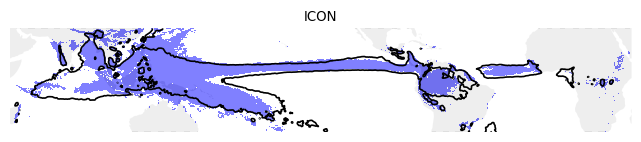

In [14]:
ax = tropdmap(trb_icon_hl,cmap=cmap_w_b,
        norm=norm_w_b,alpha=0.5)
smooth_pr_imerg.plot.contour(levels=[pr_imerg.quantile(0.8)], colors="k",transform=ccrs.PlateCarree());
ax.set_title('ICON');

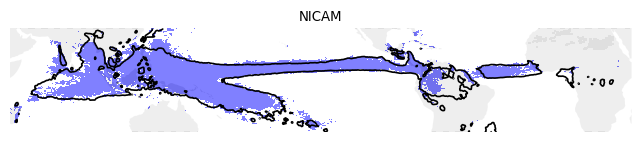

In [18]:
ax = tropdmap(trb_nicam_hl,cmap=cmap_w_b,
        norm=norm_w_b,alpha=0.5)
smooth_pr_imerg.plot.contour(levels=[pr_imerg.quantile(0.8)], colors="k",transform=ccrs.PlateCarree())
ax.set_title('NICAM');

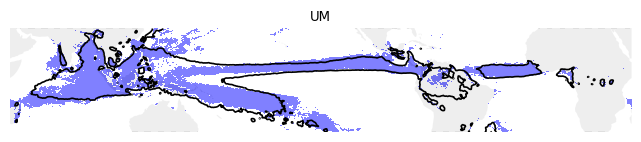

In [19]:
ax = tropdmap(trb_um_hl,cmap=cmap_w_b,
        norm=norm_w_b,alpha=0.5)
smooth_pr_imerg.plot.contour(levels=[pr_imerg.quantile(0.8)], colors="k",transform=ccrs.PlateCarree())
ax.set_title('UM');

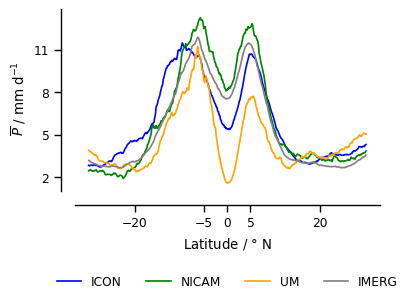

In [20]:
sns.set_context("paper")
fig = plt.figure(figsize=(10/2.54, 6/2.54), facecolor="white")
ax = fig.add_subplot(111)
pr_icon.where(trop_wpacific(pr_icon)).groupby('lat').mean().plot(label='ICON',color='blue')
pr_nicam.where(trop_wpacific(pr_nicam)).groupby('lat').mean().plot(label='NICAM',color='green')
pr_um.where(trop_wpacific(pr_um)).groupby('lat').mean().plot(label='UM',color='orange')
pr_imerg.sel(lon=slice(150,170),lat=slice(-30,30)).mean('lon').plot(label='IMERG',color='gray')
sns.despine(offset=10, ax=ax)
ax.set_xticks([-20,-5,0,5,20])
ax.set_yticks([2, 5, 8, 11])
ax.set_xlabel(None)
ax.set_ylabel(r" $\overline{P}$ / mm d$^{-1}$")
ax.set_xlabel(r"Latitude / $\degree$ N")
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.4),
    ncol=4,
    fancybox=False,
    shadow=False,
    frameon=False
)

In [114]:
pr_icon..mean()

<xarray.DataArray 'pr' ()>
array(3.46473962)

In [115]:
pr_nicam.mean()

<xarray.DataArray 'pr' ()>
array(3.54000663)
Coordinates:
    lev      float64 0.0

In [116]:
pr_um.mean()

<xarray.DataArray 'pr' ()>
array(3.4234839)
Coordinates:
    crs      float64 nan

In [2]:
list(intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"))

['CN', 'EU', 'JAPAN', 'NCAR', 'NERSC', 'UK', 'online']

In [3]:
current_location = "online"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

In [6]:
list(cat)

['ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'icon_d3hp003',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'nicam',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

In [125]:
pd.DataFrame(cat["IR_IMERG"].describe()["user_parameters"])

""


In [126]:
cat["IR_IMERG"]

IR_IMERG:
  args:
    consolidated: true
    urlpath: https://hackathon-o.s3-ext.jc.rl.ac.uk/obs-data/dev/v1/IR_IMERG_combined/IR_IMERG_combined_V07B.hp_z9.zarr
  description: ''
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: https://digital-earths-global-hackathon.github.io/catalog/online


In [128]:
%time
exp_name = "IR_IMERG"
experiment = cat[exp_name]
#time_slice = slice("2020-04-01", "2021-03-31")
ds_imerg = (
    experiment( chunks="auto")
    .to_dask()
)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 19.1 µs


In [129]:
ds_imerg

<xarray.Dataset>
Dimensions:        (time: 52609, cell: 3145728)
Coordinates:
  * cell           (cell) int64 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs            float64 ...
  * time           (time) datetime64[ns] 2019-01-01 ... 2022-01-01
Data variables:
    Tb             (time, cell) float32 dask.array<chunksize=(10, 3145728), meta=np.ndarray>
    precipitation  (time, cell) float32 dask.array<chunksize=(10, 3145728), meta=np.ndarray>
Attributes: (12/21)
    BeginDate:                 2019-01-01
    BeginTime:                 00:00:00.000Z
    EndDate:                   2019-01-01
    EndTime:                   00:59:59.999Z
    FileHeader:                StartGranuleDateTime=2019-01-01T00:00:00.000Z;...
    InputPointer:              merg_2019010100_4km-pixel
    ...                        ...
    nco_openmp_thread_number:  2
    regional:                  True
    remap_hostname:            nid004579
    remap_script:              ncremap
    remap_version:             5.2.4
    title:                     NCEP/CPC 4km Global (60N - 60S) IR Dataset

In [9]:
ds = cat["icon_d3hp003"](zoom=8).to_dask() 

In [10]:
ds

<xarray.Dataset>
Dimensions:        (time: 425, cell: 786432, crs: 1, pressure: 30,
                    soil_level: 5, pressure_rva: 3)
Coordinates:
  * crs            (crs) float32 nan
  * pressure       (pressure) int64 5 10 20 50 100 ... 92500 95000 97500 100000
  * pressure_rva   (pressure_rva) int64 16 18 23
  * soil_level     (soil_level) int64 0 0 0 2 6
  * time           (time) datetime64[ns] 2020-01-02 2020-01-03 ... 2021-03-01
Dimensions without coordinates: cell
Data variables: (12/58)
    clivi          (time, cell) float32 ...
    clt            (time, cell) float32 ...
    clwvi          (time, cell) float32 ...
    egpvi          (time, cell) float32 ...
    einvi          (time, cell) float32 ...
    ekhvi          (time, cell) float32 ...
    ...             ...
    ua             (time, pressure, cell) float32 ...
    uas            (time, cell) float32 ...
    va             (time, pressure, cell) float32 ...
    vas            (time, cell) float32 ...
    wa             (time, pressure, cell) float32 ...
    zg             (time, pressure, cell) float32 ...